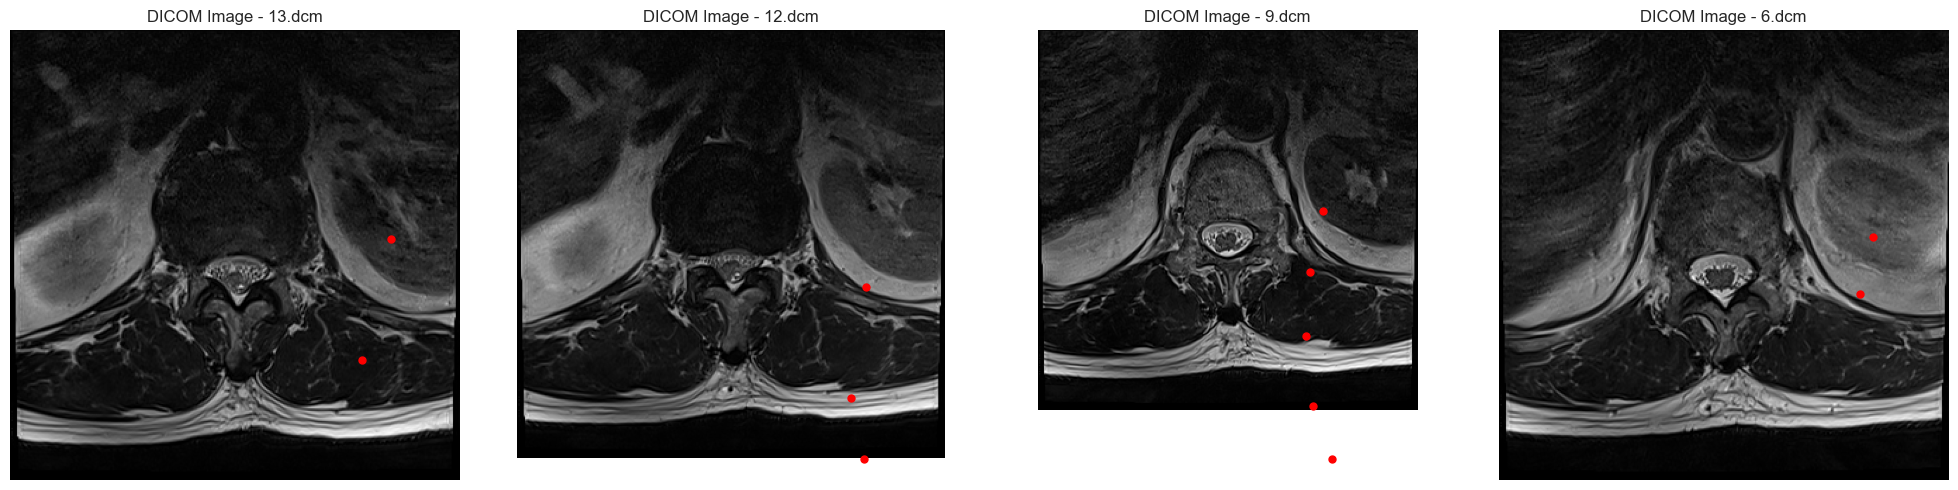

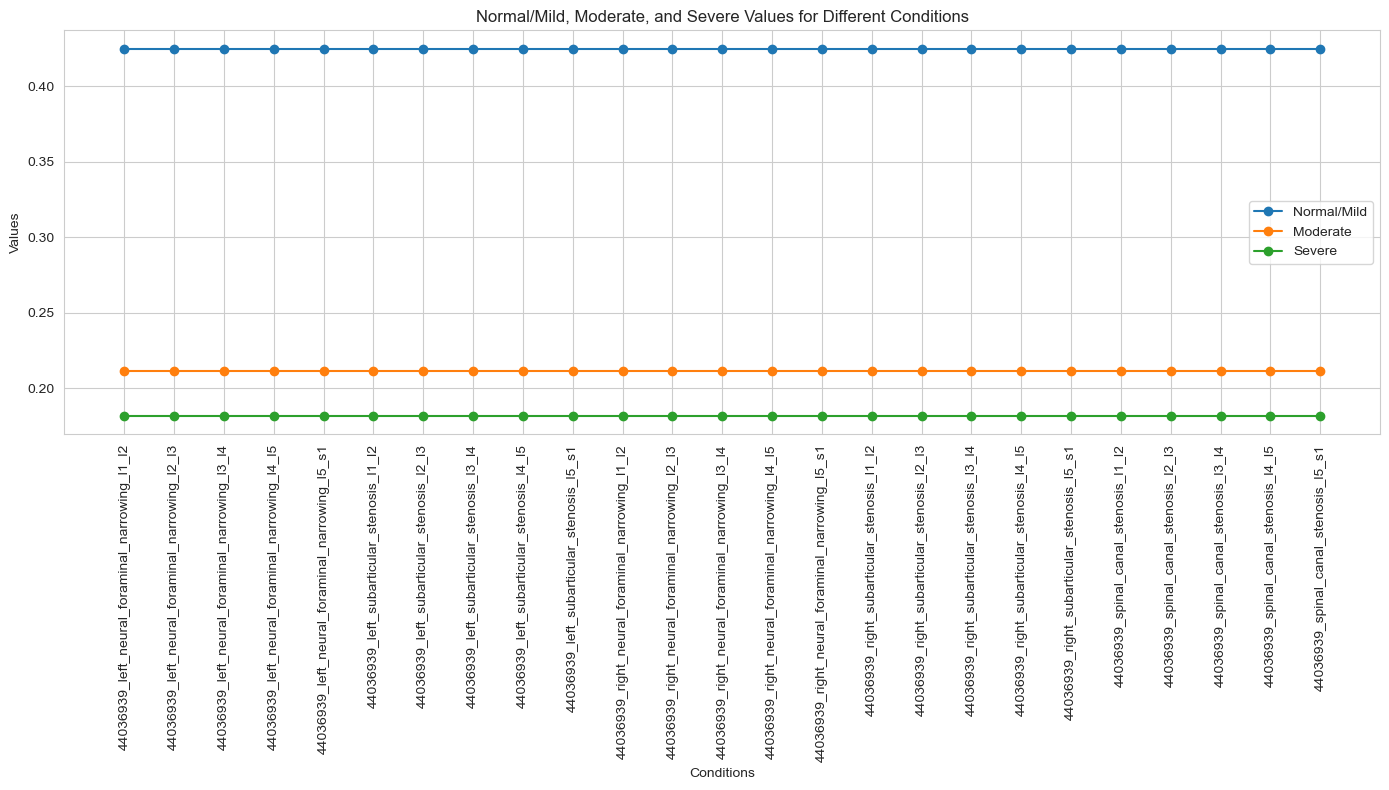

In [16]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pydicom as dicom
import pydicom
import random
import warnings
warnings.filterwarnings('ignore')
folder_path = '/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084'
dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
label_coordinates_df = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_series = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
df_train = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
df_sub = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
test_series = pd.read_csv('/Users/devnikhil/Documents/med/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
label_coordinates_df.head()


label_coordinates_df.shape




study_id = folder_path.split('/')[-2]
study_label_coordinates = label_coordinates_df[label_coordinates_df['study_id'] == int(study_id)]
filtered_dicom_files = []
filtered_label_coordinates = []

for dicom_file in dicom_files:
    instance_number = int(dicom_file.split('.')[0])
    corresponding_coordinates = study_label_coordinates[study_label_coordinates['instance_number'] == instance_number]
    if not corresponding_coordinates.empty:
        filtered_dicom_files.append(dicom_file)
        filtered_label_coordinates.append(corresponding_coordinates)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
second_row_index = 1
second_row_images = filtered_dicom_files[second_row_index : second_row_index + 4]
second_row_coordinates = filtered_label_coordinates[second_row_index : second_row_index + 4]

for i, (dicom_file, label_coordinates) in enumerate(zip(second_row_images, second_row_coordinates)):
    dicom_file_path = os.path.join(folder_path, dicom_file)
    dicom_data = pydicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array   
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'DICOM Image - {dicom_file}')
    axs[i].axis('off')   
    for _, row in label_coordinates.iterrows():
        axs[i].plot(row['x'], row['y'], 'ro', markersize=5) 
        
plt.tight_layout()
plt.show()

df_train.head()


df_sub.head()


test_series.head()

train_series.head()

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='severity')
df_train_melted[['condition', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]

le_severity = LabelEncoder()
df_train_melted['severity_encoded'] = le_severity.fit_transform(df_train_melted['severity'])

X_train = df_train_melted[['study_id', 'condition', 'level']]
y_train = df_train_melted['severity_encoded']

X_train = pd.get_dummies(X_train, columns=['condition', 'level'])
test_rows = []
for _, row in test_series.iterrows():
    for condition in ['left_neural_foraminal_narrowing', 'right_neural_foraminal_narrowing', 'left_subarticular_stenosis', 'right_subarticular_stenosis', 'spinal_canal_stenosis']:
        for level in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
            test_rows.append({
                'study_id': row['study_id'],
                'condition': condition,
                'level': level
            })

X_test = pd.DataFrame(test_rows)
X_test = pd.get_dummies(X_test, columns=['condition', 'level'])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
df_train_melted

X_train


X_test


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
RandomForestClassifier(random_state=42)

predictions_proba = model.predict_proba(X_test)
predictions_proba = np.exp(predictions_proba) / np.sum(np.exp(predictions_proba), axis=1, keepdims=True)
predictions_df = pd.DataFrame(predictions_proba, columns=le_severity.classes_)
predictions_df['study_id'] = X_test['study_id']
predictions_df['condition_level'] = X_test.index.map(lambda idx: '_'.join(X_test.iloc[idx].index[-10:].values))
predictions_df['condition'], predictions_df['level'] = zip(*predictions_df['condition_level'].apply(lambda x: ('_'.join(x.split('_')[:-1]), x.split('_')[-1])))
predictions_df = predictions_df[['study_id', 'condition', 'level', 'Normal/Mild', 'Moderate', 'Severe']]
normal_mild_value = predictions_df['Normal/Mild'].iloc[0]
moderate_value = predictions_df['Moderate'].iloc[0]
severe_value = predictions_df['Severe'].iloc[0]

df_sub['normal_mild'] = normal_mild_value
df_sub['moderate'] = moderate_value
df_sub['severe'] = severe_value
df_sub.sample(4)

plt.figure(figsize=(14, 8))
plt.plot(df_sub['row_id'], df_sub['normal_mild'], label='Normal/Mild', marker='o')
plt.plot(df_sub['row_id'], df_sub['moderate'], label='Moderate', marker='o')
plt.plot(df_sub['row_id'], df_sub['severe'], label='Severe', marker='o')

plt.xlabel('Conditions')
plt.ylabel('Values')
plt.title('Normal/Mild, Moderate, and Severe Values for Different Conditions')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

df_sub.to_csv('submission.csv', index=False)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC

y_pred = model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)

# Calculate precision, recall, and F1-score (one vs rest approach)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy of the Random Forest Model:", accuracy)
print("Precision (weighted average):", precision)
print("Recall (weighted average):", recall)
print("F1-score (weighted average):", f1)
print("\n")

models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(objective='multi:softprob', random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
}

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the labels for the training data
    y_pred = model.predict(X_train)
    
    # Calculate metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')
    
    # Print the evaluation metrics
    print(f"Evaluation metrics for {model_name}:")
    print("Accuracy:", accuracy)
    print("Precision (weighted average):", precision)
    print("Recall (weighted average):", recall)
    print("F1-score (weighted average):", f1)
    print("\n")


Accuracy of the Random Forest Model: 0.8268962025316455
Precision (weighted average): 0.8080678932682143
Recall (weighted average): 0.8268962025316455
F1-score (weighted average): 0.812587681091811


Evaluation metrics for Gradient Boosting:
Accuracy: 0.7660759493670886
Precision (weighted average): 0.734289147089713
Recall (weighted average): 0.7660759493670886
F1-score (weighted average): 0.6668979286968169


Evaluation metrics for XGBoost:
Accuracy: 0.7651645569620253
Precision (weighted average): 0.6595902275909795
Recall (weighted average): 0.7651645569620253
F1-score (weighted average): 0.6665498928858451


Evaluation metrics for Support Vector Machine:
Accuracy: 0.7646379746835443
Precision (weighted average): 0.5846712323281525
Recall (weighted average): 0.7646379746835443
F1-score (weighted average): 0.6626528961930592




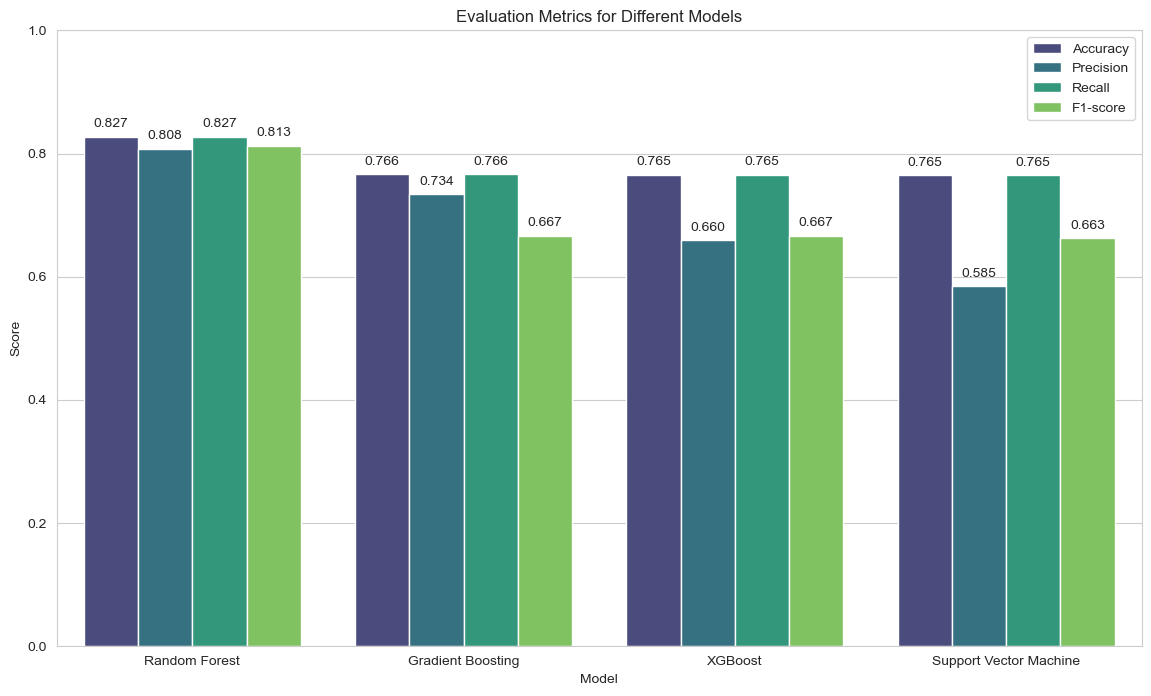

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data preparation
data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Support Vector Machine'],
    'Accuracy': [0.8268962025316455, 0.7660759493670886, 0.7651645569620253, 0.7646379746835443],
    'Precision': [0.8080678932682143, 0.734289147089713, 0.6595902275909795, 0.5846712323281525],
    'Recall': [0.8268962025316455, 0.7660759493670886, 0.7651645569620253, 0.7646379746835443],
    'F1-score': [0.812587681091811, 0.6668979286968169, 0.6665498928858451, 0.6626528961930592]
}

# Convert the data to a pandas DataFrame
df_metrics = pd.DataFrame(data)

# Melt the DataFrame to have a suitable format for seaborn
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
barplot = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette='viridis')
plt.title('Evaluation Metrics for Different Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='upper right')

# Adding annotations
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.3f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.show()


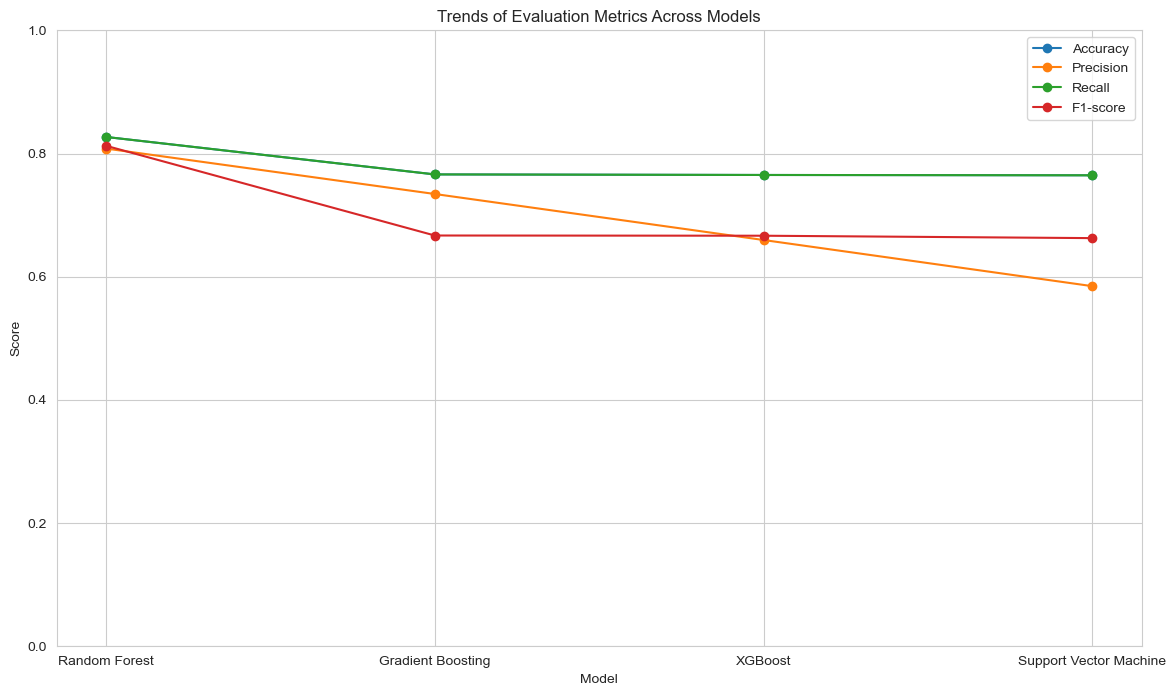

In [8]:
plt.figure(figsize=(14, 8))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    plt.plot(df_metrics['Model'], df_metrics[metric], marker='o', label=metric)

plt.title('Trends of Evaluation Metrics Across Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


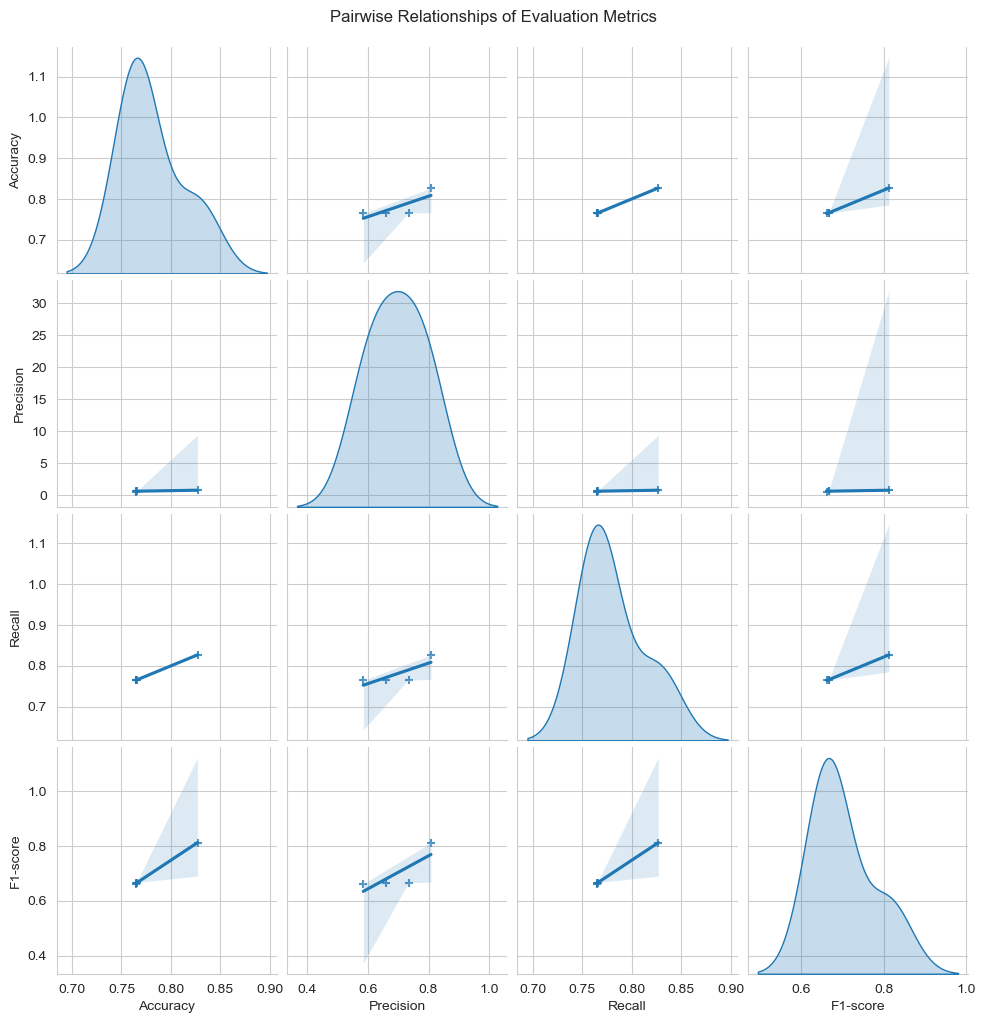

In [11]:
sns.pairplot(df_metrics, kind='reg', diag_kind='kde', markers='+')
plt.suptitle('Pairwise Relationships of Evaluation Metrics', y=1.02)
plt.show()


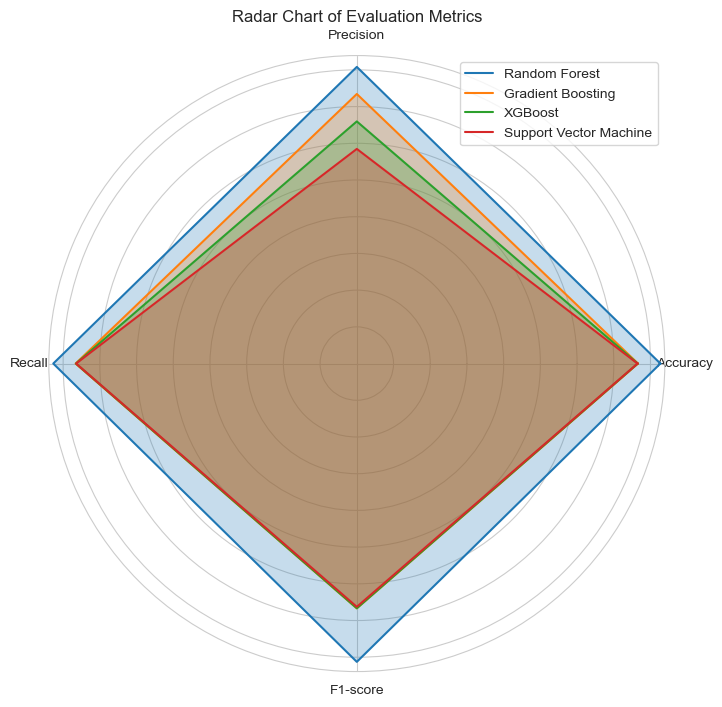

In [12]:
categories = ['Accuracy', 'Precision', 'Recall', 'F1-score']
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df_metrics.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Model'])
    ax.fill(angles, values, alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart of Evaluation Metrics')
plt.legend(loc='upper right')
plt.show()
